In [126]:
import bisect
import datetime
import json
import random
import seaborn
import numpy
import pandas
import math
import scipy
from matplotlib import pyplot
import matplotlib
%matplotlib inline

In [127]:
matplotlib.rcParams.update({'font.size': 48})

In [337]:
stations = {}
for i, line in enumerate(open('log.jsons')):
    if i > 2:
        for j,vehicle in enumerate(json.loads(line.strip())):
            if vehicle.get('current_status') != 1:
                continue
            try:
                line = vehicle['trip']['route_id'].rstrip('X')
                if line not in ['1','2','3','4','5','6','GS','L','SI']:
                    print 'weird line', line
                if 'stop_id' in vehicle:
                    stop = vehicle['stop_id']
                else:
                    stop = '%d%s'%(vehicle['current_stop_sequence'],vehicle['trip']['trip_id'][-1])
                key = (line, stop)
                timestamp = vehicle['timestamp']
                stations.setdefault(key,set()).add(timestamp)
            except:
                print 'weird vehicle', vehicle
                continue
print i

5145


In [338]:
lengths = []
for key in stations.keys():
    lengths.append(len(stations[key]))
print sorted(lengths)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 15, 24, 25, 25, 26, 29, 29, 30, 30, 31, 33, 33, 35, 37, 37, 40, 40, 41, 42, 42, 42, 43, 43, 43, 43, 44, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 5

In [339]:
def next_whole_minute(t):
    return t+59 - (t+59)%60

In [340]:
deltas = []
next_subway = []
next_subway_by_time_of_day = [[] for x in xrange(24 * 60)] #one for each minute
next_subway_by_line_ts = []
next_subway_by_line_ls = []
next_subway_rush_hour = []
max_limit = 4 * 3600 #4 hours

def to_eastern(time):
    return timezone('UTC').localize(time).astimezone(timezone('US/Eastern')).time()

for key, values in stations.iteritems():
    line, stop = key
    values = sorted(values)
    #print key, map(str,map(to_eastern, map(datetime.datetime.utcfromtimestamp, values)))
    
    last_value = None
    
    for i in xrange(1, len(values)):
        last_value, value = values[i-1], values[i]
        if value - last_value >= max_limit: #more than 4 hours
            continue
        deltas.append(1. / 60 * (value - last_value)) #add wait time btwn trains in minutes
        
        for t in xrange(next_whole_minute(last_value), value, 60): #for each minute between last_value and value
            x = (t // 60 + 19 * 60) % (24 * 60) #convert to eastern time, remove date
            waiting_time = 1. / 60 * (value - t) #for arriving at minute t, the next train is value, so wait time is value - t
            next_subway_by_time_of_day[x].append(waiting_time) #add wait time to that minute
            next_subway.append(waiting_time) #general array of wait times
            next_subway_by_line_ts.append(waiting_time) 
            next_subway_by_line_ls.append(line) #which line does each wait time correspond to
            if x >= 7 * 60 and x < 19 * 60:
                next_subway_rush_hour.append(waiting_time) #only wait times btwn 7am - 7pm        

In [290]:
def to_seconds(time_str):
    hr, mn, sec = map(int,time_str.split(':'))
    return sec + 60*mn + 3600*hr

In [291]:
stations_sched = {}
for i, line in enumerate(open('../Data/stop_times.txt')):
    if i != 0:
        trip_id, arrival, _, stop_id = line.strip().split(',')[:4]
        line = trip_id.split('_')[-1].split('.')[0]
        day = trip_id.split('_')[0][-3:]
        arrival = to_seconds(arrival)
        
        key = (line, stop_id)
        stations_sched.setdefault(key, set()).add(arrival)

In [292]:
deltas_sched = []
next_subway_sched = []
next_subway_by_time_of_day_sched = [[] for x in xrange(24 * 60)] #one for each minute
next_subway_by_line_ts_sched = []
next_subway_by_line_ls_sched = []
next_subway_rush_hour_sched = []
max_limit = 4 * 3600 #4 hours

for key, values in stations_sched.iteritems():
    line, stop = key
    values = sorted(values)
    last_value = None
    for i in xrange(1,len(values)):
        last_value, value = values[i-1], values[i]
        if value - last_value >= max_limit: #more than 4 hours
            continue
        deltas_sched.append(1. / 60 * (value - last_value))
        for t in xrange(next_whole_minute(last_value), value, 60): #for each minute between last_value and value
            x = (t // 60 + 19 * 60) % (24 * 60) #convert to eastern time, remove date
            waiting_time = 1. / 60 * (value - t) #for arriving at minute t, the next train is value, so wait time is value - t
            next_subway_by_time_of_day_sched[x].append(waiting_time) #add wait time to that minute
            next_subway_sched.append(waiting_time) #general array of wait times
            next_subway_by_line_ts_sched.append(waiting_time) 
            next_subway_by_line_ls_sched.append(line) #which line does each wait time correspond to
            if x >= 7 * 60 and x < 19 * 60:
                next_subway_rush_hour_sched.append(waiting_time) #only wait times btwn 7am - 7pm 

got 17356 points
mean 399.644560959 median 340.5


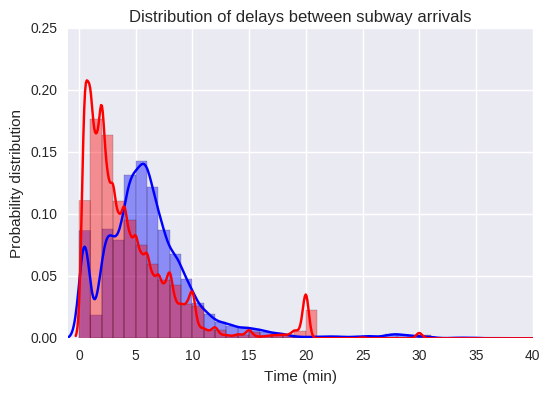

In [293]:
data = deltas
data2 = deltas_sched
title = 'Distribution of delays between subway arrivals'
color = 'blue'
color2 = 'red'

print 'got', len(data), 'points'
pyplot.clf()
lm  = seaborn.distplot(data, bins=numpy.linspace(0,60,num=61), color=color, kde_kws={'gridsize': 2000})
lm2  = seaborn.distplot(data2, bins=numpy.linspace(0,60,num=61), color=color2, kde_kws={'gridsize': 2000})
pyplot.xlim([-1, 40])
pyplot.title(title)
pyplot.xlabel('Time (min)')
pyplot.ylabel('Probability distribution')
print 'mean', 60*numpy.mean(data), 'median', 60*numpy.median(data)

got 115609 points
mean 385.66948075 median 228.0


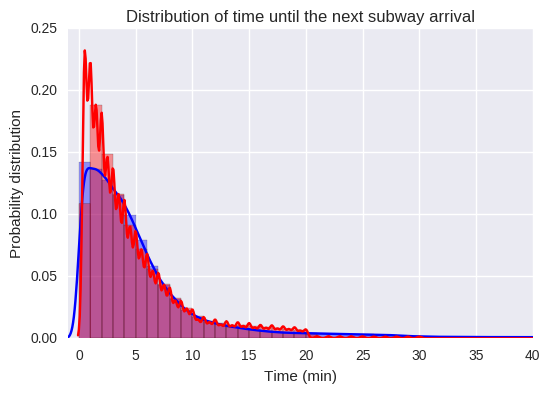

In [294]:
data = next_subway
data2 = next_subway_sched
title = 'Distribution of time until the next subway arrival'
color = 'blue'
color2 = 'red'

print 'got', len(data), 'points'
pyplot.clf()
lm  = seaborn.distplot(data, bins=numpy.linspace(0,60,num=61), color=color, kde_kws={'gridsize': 2000})
lm2  = seaborn.distplot(data2, bins=numpy.linspace(0,60,num=61), color=color2, kde_kws={'gridsize': 2000})
pyplot.xlim([-1, 40])
pyplot.title(title)
pyplot.xlabel('Time (min)')
pyplot.ylabel('Probability distribution')
print 'mean', 60*numpy.mean(data), 'median', 60*numpy.median(data)

In [298]:
set(next_subway_by_line_ls_sched)

{'1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'FS',
 'G',
 'GS',
 'H',
 'J',
 'L',
 'M',
 'N',
 'Q',
 'R',
 'SI'}

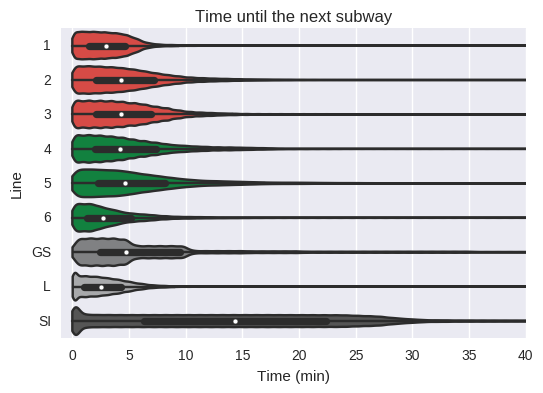

In [301]:
pyplot.clf()
seaborn.violinplot(orient='h', x=next_subway_by_line_ts, y=next_subway_by_line_ls,
                   order=['1','2','3','4','5','6','GS','L','SI'], scale='width', 
                   palette=['#EE352E']*3 + ['#00933C']*3 + ['#808183', '#A7A9AC', '#555555'],
                   bw=0.03, cut=0, gridsize=2000
                  )
pyplot.xlim([-1,40])
pyplot.title('Time until the next subway')
pyplot.xlabel('Time (min)')
pyplot.ylabel('Line')

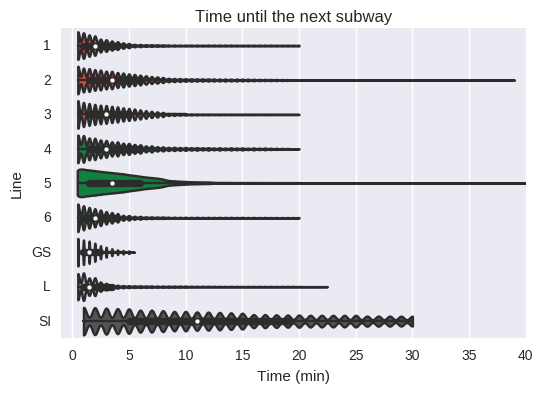

In [300]:
pyplot.clf()
seaborn.violinplot(orient='h', x=next_subway_by_line_ts_sched, y=next_subway_by_line_ls_sched,
                   order=['1','2','3','4','5','6','GS','L','SI'], scale='width', 
                   palette=['#EE352E']*3 + ['#00933C']*3 + ['#808183', '#A7A9AC', '#555555'],
                   bw=0.03, cut=0, gridsize=2000
                  )
pyplot.xlim([-1,40])
pyplot.title('Time until the next subway')
pyplot.xlabel('Time (min)')
pyplot.ylabel('Line')

In [341]:
percs = [50, 60, 70, 80, 90]
results = [[] for perc in percs]
results_sched = [[] for perc in percs]
xs = range(0, 24 * 60)
for x, next_subway_slice in enumerate(next_subway_by_time_of_day):
    #print x, len(next_subway_slice), '...'
    if len(next_subway_slice) != 0:
        rs = numpy.percentile(next_subway_slice, percs)
    else:
        rs = numpy.percentile(0,percs)
    for i, r in enumerate(rs):
        results[i].append(r)
        
for x, next_subway_slice in enumerate(next_subway_by_time_of_day_sched):
    #print x, len(next_subway_slice), '...'
    if len(next_subway_slice) != 0:
        rs = numpy.percentile(next_subway_slice, percs)
    else:
        rs = numpy.percentile(0,percs)
    for i, r in enumerate(rs):
        results_sched[i].append(r)

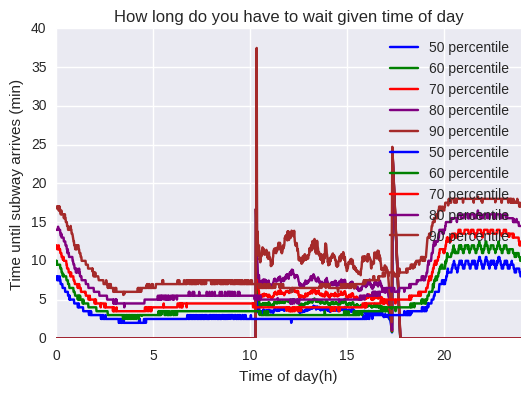

In [342]:
pyplot.clf()
colors = ['blue','green','red','purple','brown']
for i, result in enumerate(results):
    #print len(xs), len(result)
    pyplot.plot([x * 1.0 / 60 for x in xs], result, label='%d percentile'%percs[i], color=colors[i])
for i, result in enumerate(results_sched):
    #print len(xs), len(result)
    pyplot.plot([x * 1.0 / 60 for x in xs], result, label='%d percentile'%percs[i], color=colors[i])
#pyplot.ylim([0,30])
pyplot.xlim([0,24])
pyplot.title('How long do you have to wait given time of day')
pyplot.xlabel('Time of day(h)')
pyplot.ylabel('Time until subway arrives (min)')
pyplot.legend()

In [281]:
results = [[] for perc in percs]
offsets = numpy.arange(0,40,0.1)
for offset in offsets:
    #print offset, '...'
    rs = numpy.percentile([d-offset for d in next_subway_rush_hour if d >= offset], percs)
    for i, r in enumerate(rs):
        results[i].append(r)

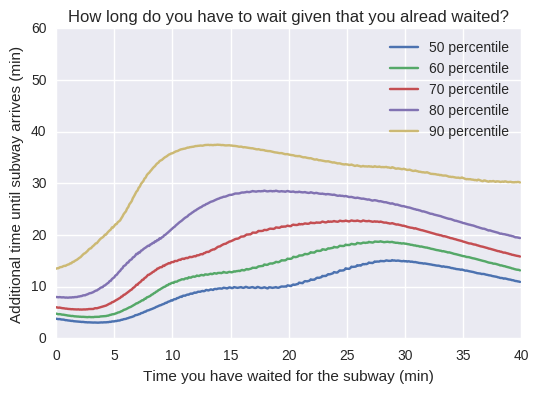

In [282]:
pyplot.clf()
for i, result in enumerate(results):
    pyplot.plot(offsets, result, label='%d percentile'%percs[i])
pyplot.ylim([0, 60])
pyplot.title('How long do you have to wait given that you alread waited?')
pyplot.xlabel('Time you have waited for the subway (min)')
pyplot.ylabel('Additional time until subway arrives (min)')
pyplot.legend()

In [5]:
def parse_time(t):
    h, m, s = map(int, t.split(':'))
    return h*60*60 + m*60 + s

In [15]:
sched_trips = {}
for i, line in enumerate(open('../Data/stop_times_updated.txt')):
    line = line.strip().split(',')
    if i>0:
        _, trip_id, stop_id, _, _, _, _, _, _, _, arr, dep = line
        if 'WKD' not in trip_id:
            continue
        line = trip_id.split('_')[2].split('.')[0]
        key = (stop_id, line)
        arr = parse_time(arr)
        sched_trips.setdefault(key, []).append(arr)
    if i==1000:
        break

In [36]:
MAX = 1800 #30 minutes
max_time = 4*3600

xs = []
ys = []
ys_by_x = [[] for x in xrange(MAX/60)]

for key, stops in sched_trips.iteritems():
    #print key
    stop_id, line = key
    stops = sorted(stops)
    
    if len(stops)<5:
        print key, 'not enough stops'
        continue
    
    lo = stops[0]
    hi = stops[-1]
    for i in xrange(len(stops)):
        t = lo + random.random() * (hi-lo)
        #j = bisect.bisect(stops, t)
        #t0, t1 = stops[j-1], stops[j]
        #if t1-t0 > max_time:
        #    print t1, t0, 'too large'
        #    continue
        #real_wait_time = t1 - t
        u = (t + (19*60*60)) % (24 * 60 * 60)
        j = bisect.bisect(stops,u)
        if j < len(stops):
            u1 = stops[j]
        else:
            u1 = 24 * 60 * 60 + stops[0]
        sched_wait_time = u1 - u
        
        if sched_wait_time < MAX:
            xs.append(sched_wait_time / 60.)

('255N', '2') not enough stops
('251N', '2') not enough stops
('248S', '2') not enough stops
('248N', '5') not enough stops
('257N', '2') not enough stops
('256N', '5') not enough stops
('253S', '2') not enough stops
('255S', '2') not enough stops
('249S', '2') not enough stops
('A12N', 'B') not enough stops
('254S', '2') not enough stops
('254N', '5') not enough stops
('251S', '2') not enough stops
('257S', '2') not enough stops
('252N', '2') not enough stops
('249N', '2') not enough stops
('251N', '5') not enough stops
('252S', '2') not enough stops
('256S', '2') not enough stops
('255N', '5') not enough stops
('250S', '2') not enough stops
('201N', '5') not enough stops
('250N', '2') not enough stops
('253N', '5') not enough stops
('254N', '2') not enough stops
('F01N', 'E') not enough stops
('256N', '2') not enough stops
('252N', '5') not enough stops
('F03N', 'E') not enough stops
('253N', '2') not enough stops
('257N', '5') not enough stops
('248N', '2') not enough stops
('249N',